In [239]:
import pandas as pd
import torch

### 遇到什么解决什么

### Mnist分类任务

In [240]:
print(torch.__version__)

2.4.0


In [241]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [242]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [243]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

In [244]:
# 查看x_train[0]中不为0的元素
x_train[0].reshape((28,28)).shape

(28, 28)

(50000, 784)


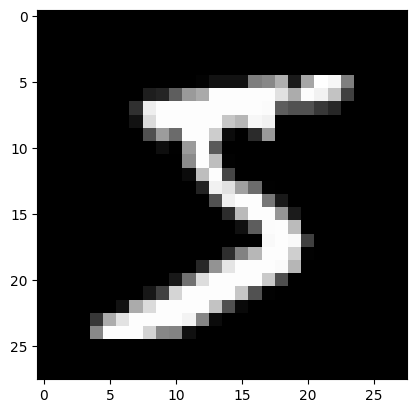

In [245]:
# 将x_train[0]转化为二维数组
pyplot.imshow(x_train[0].reshape((28,28)), cmap='gray')
print(x_train.shape)

#### 数据需要转化为tensor才能参与后续模型训练

In [246]:
x_train,y_train,x_valid,y_valid=map(
    torch.tensor,(x_train,y_train,x_valid,y_valid)
)
n,c=x_train.shape
x_train,x_train.shape,y_train.min(),y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

In [247]:
import torch.nn.functional as F

In [248]:
loss_func=F.cross_entropy # 需要传入预测值和真实值, 损失函数
# print(loss_func)
def model(xb):
    return xb.mm(weights)+bias

In [249]:
bs=64
xb=x_train[:bs]
# print(xb.shape)
yb=y_train[:bs]
#用于指定一个张量（Tensor）是否需要计算梯度，也就是是否需要梯度信息来更新参数
weights=torch.randn([784,10],dtype=torch.float,requires_grad=True)  
bs=64
bias=torch.zeros(10,requires_grad=True)
print(loss_func(model(xb),yb))

tensor(14.8340, grad_fn=<NllLossBackward0>)


In [250]:
xb.shape

torch.Size([64, 784])

### 创建model简化代码

In [251]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(784,128)
        self.hidden2=nn.Linear(128,256)
        self.out=nn.Linear(256,10)
        self.dropout=nn.Dropout(0.5)

    def forward(self,x):
        x=F.relu(self.hidden1(x))
        x=self.dropout(x)
        x=F.relu(self.hidden2(x))
        x=self.dropout(x)
        x=self.out(x)
        return x

In [252]:
net=Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


#### 打印我们定义好名字里的和偏置项

In [280]:
for name,parameter in net.named_parameters():
    print(name,parameter.shape)

hidden1.weight torch.Size([128, 784])
hidden1.bias torch.Size([128])
hidden2.weight torch.Size([256, 128])
hidden2.bias torch.Size([256])
out.weight torch.Size([10, 256])
out.bias torch.Size([10])


In [254]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_ds=TensorDataset(x_train,y_train)
train_dl=DataLoader(train_ds,batch_size=bs,shuffle=True)

valid_ds=TensorDataset(x_valid,y_valid)
valid_dl=DataLoader(valid_ds,batch_size=bs*2)

In [255]:
def get_data(train_ds,valid_ds,bs=64):
    return (
        DataLoader(train_ds,batch_size=bs,shuffle=True),
        DataLoader(valid_ds,batch_size=bs*2)
    )

In [256]:
import numpy as np

def fit(steps,model,loss_func,opt,train_dl,valid_dl):
    for step in range(steps):
        model.train()
        for xb,yb in train_dl:
            loss_batch(model,loss_func,xb,yb,opt)

        model.eval()
        with torch.no_grad():
            losses,nums=zip(
                *[loss_batch(model,loss_func,xb,yb) for xb,yb in valid_dl]
            )
        val_loss=np.sum(np.multiply(losses,nums))/np.sum(nums)
        print('当前step:'+str(step),'验证集损失：'+str(val_loss))

In [257]:
net.train()
for xb,yb in train_dl:
    loss_batch(net,loss_func,xb,yb)
    # print(loss_batch(net,loss_func,xb,yb))
    break

In [266]:
from torch import optim
def get_model():
    model=Mnist_NN()
    return model,optim.Adam(model.parameters(),lr=0.001)

In [267]:
def loss_batch(model,loss_func,xb,yb,opt=None):
    loss=loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(),len(xb)

In [268]:
train_dl,valid_dl=get_data(train_ds,valid_ds)
model,opt=get_model()
fit(20 ,model,loss_func,opt,train_dl,valid_dl)

当前step:0 验证集损失：0.19177670898884536
当前step:1 验证集损失：0.1349820826806128
当前step:2 验证集损失：0.12878794861212373
当前step:3 验证集损失：0.1063480374192819
当前step:4 验证集损失：0.10054083606172352
当前step:5 验证集损失：0.0930113324765116
当前step:6 验证集损失：0.09188264991175384
当前step:7 验证集损失：0.09206295750327409
当前step:8 验证集损失：0.08719605334894731
当前step:9 验证集损失：0.08705709825986996
当前step:10 验证集损失：0.08526215053983033
当前step:11 验证集损失：0.08234239420630038
当前step:12 验证集损失：0.08385423739198596
当前step:13 验证集损失：0.08175767680975841
当前step:14 验证集损失：0.08098367426011245
当前step:15 验证集损失：0.08689494291138836
当前step:16 验证集损失：0.08479441619021819
当前step:17 验证集损失：0.0778475485629635
当前step:18 验证集损失：0.08153048715456389
当前step:19 验证集损失：0.0824262356017367


In [279]:
correct=0
total=0
for xb,yb in valid_dl:
    outputs=model(xb)
    _,predicted=torch.max(outputs.data,1)
    total+=yb.size(0)
    correct+=(predicted==yb).sum().item()

print("准确率：%d%%" % (100*correct/total))

准确率：97%
